Tässä notebookissa tehdään Silver-tason prosessoinnit datalle, eli ladataan bronze_pipeline.ipynb ETL-putken luomat lopputulokset ja otetaan data esikäsittellyyn. Esikäsittelyssä data putsataan ja prosessoidaan haluttuun muotoon. Tämän jälkeen data tallennetaan Gold-tason tauluun, joka toimii datan lopullisena tallennuspaikkana, josta sitä käytetään tämän projektin muissa välivaiheissa. Otetaan Polars käyttöön, jotta voidaan nopeuttaa ja tehostaa datan prosessointia. Polars on Pandasin kaltainen kirjasto, mutta sen avulla voidaan isoja datamassoja prosessoida nopeammin. (Se on kai optimoitu paremmin tms.)

In [1]:
!pip install duckdb
!pip install polars


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [203]:
import duckdb
import pandas as pd
duckdb_path = "data/duckdb.database" # Duckdb tietokannalle annettava nimi, tallentuu lokaalisti
table_name = "Bronze_SensorData" # Tietokantataulu, josta luetaan, voi olla myös esim Bronze_SensorData_lite

# Ota yhteys tietokantaa ja tarkista mitä dataa taulusta löytyy
conn = duckdb.connect(database=duckdb_path)
conn.table(table_name).show()
conn.close()

┌─────────┬──────────────────────────────────┬───────┬───────┬───────┬───────┐
│ node_id │            timestamp             │   x   │   y   │   z   │   q   │
│  int32  │             varchar              │ int32 │ int32 │ int32 │ int32 │
├─────────┼──────────────────────────────────┼───────┼───────┼───────┼───────┤
│    3200 │ 2019-03-07 11:46:19.078016+00:00 │     0 │     0 │     0 │    51 │
│    3200 │ 2019-03-07 11:46:20.078012+00:00 │     0 │     0 │     0 │   163 │
│    3200 │ 2019-03-07 11:46:21.078081+00:00 │     0 │     0 │     0 │    42 │
│    3200 │ 2019-03-07 11:46:22.07813+00:00  │     0 │     0 │     0 │   105 │
│    3200 │ 2019-03-13 15:29:43.686639+00:00 │   -50 │    50 │     0 │   106 │
│    3200 │ 2019-03-13 15:29:44.686592+00:00 │   -50 │    50 │     0 │    76 │
│    3200 │ 2019-03-13 15:29:45.686654+00:00 │   -50 │    50 │     0 │    68 │
│    3200 │ 2019-03-13 15:29:46.686785+00:00 │   -50 │    50 │     0 │   142 │
│    3200 │ 2019-03-13 15:29:47.687715+00:00 │   -50

Otetaan käyttöön Polars, koska sen avulla voidaan prosessoida isoja datamassoja nopeammin kuin Pandasilla.
Lyhenti prosessointiaikoja merkittävästi.

In [204]:
import duckdb
import pandas as pd
import polars as pl

# Ota yhteys tietokantaa ja tarkista mitä dataa taulusta löytyy
conn = duckdb.connect(database=duckdb_path)
df = conn.sql(f"SELECT * FROM {table_name}").pl() # Tallenentaan taulun data Polars dataframeen
conn.close()

In [205]:
df

node_id,timestamp,x,y,z,q
i32,str,i32,i32,i32,i32
3200,"""2019-03-07 11:…",0,0,0,51
3200,"""2019-03-07 11:…",0,0,0,163
3200,"""2019-03-07 11:…",0,0,0,42
3200,"""2019-03-07 11:…",0,0,0,105
3200,"""2019-03-13 15:…",-50,50,0,106
…,…,…,…,…,…
54016,"""2020-01-23 13:…",949,3649,0,110
54016,"""2020-01-23 13:…",949,3649,0,110
54016,"""2020-01-23 13:…",949,3649,0,110


In [206]:
# Tässä prosessoinnin vaiheessa poistetaan Z & Q sarakkeet

df = df.drop(columns=['z', 'q'])
print(df.describe())
#df.info(verbose=True)

C:\Users\lints\AppData\Local\Temp\ipykernel_4072\992959508.py:3: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  df = df.drop(columns=['z', 'q'])


shape: (9, 5)
┌────────────┬──────────────┬──────────────────────────────────┬─────────────┬─────────────┐
│ statistic  ┆ node_id      ┆ timestamp                        ┆ x           ┆ y           │
│ ---        ┆ ---          ┆ ---                              ┆ ---         ┆ ---         │
│ str        ┆ f64          ┆ str                              ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════════════════════════╪═════════════╪═════════════╡
│ count      ┆ 1.3996156e8  ┆ 139961560                        ┆ 1.3996156e8 ┆ 1.3996156e8 │
│ null_count ┆ 0.0          ┆ 0                                ┆ 0.0         ┆ 0.0         │
│ mean       ┆ 45784.672629 ┆ null                             ┆ 799.907906  ┆ 2587.673834 │
│ std        ┆ 16863.539458 ┆ null                             ┆ 2339.921248 ┆ 1329.330248 │
│ min        ┆ 3200.0       ┆ 2019-03-06 15:26:12.078161+00:00 ┆ -32818.0    ┆ -32718.0    │
│ 25%        ┆ 51751.0      ┆ null                      

In [207]:
# Tässä prosessoinnin vaiheessa laitetaan oikea tietotyyppi timestamp sarakkeelle (datetime)
df = df.with_columns(
    pl.col("timestamp").str.to_datetime("%Y-%m-%d %H:%M:%S.%f%z").alias("timestamp")
)
df

C:\Users\lints\AppData\Local\Temp\ipykernel_4072\3696836717.py:4: ChronoFormatWarning: Detected the pattern `.%f` in the chrono format string. This pattern should not be used to parse values after a decimal point. Use `%.f` instead. See the full specification: https://docs.rs/chrono/latest/chrono/format/strftime
  pl.col("timestamp").str.to_datetime("%Y-%m-%d %H:%M:%S.%f%z").alias("timestamp")


node_id,timestamp,x,y
i32,"datetime[ns, UTC]",i32,i32
3200,2019-03-07 11:46:19.000078016 UTC,0,0
3200,2019-03-07 11:46:20.000078012 UTC,0,0
3200,2019-03-07 11:46:21.000078081 UTC,0,0
3200,2019-03-07 11:46:22.000007813 UTC,0,0
3200,2019-03-13 15:29:43.000686639 UTC,-50,50
…,…,…,…
54016,2020-01-23 13:07:24.000478952 UTC,949,3649
54016,2020-01-23 13:07:25.000479218 UTC,949,3649
54016,2020-01-23 13:07:25.000479252 UTC,949,3649


In [208]:
# Filteröidään ajan mukaan, poistetaan rivit joissa kärryä on liikuteltu kaupan oletettujen aukioloaikojen ulkopuolella
from datetime import time

# Filteröidään aukioloajat kello 8:00 - 21:00
# Tässä voisi ehkä erikseen filteröidä vklp aukioloaikoja tai kovakoodata pyhäpäiviä tms?
start_time = time(8, 0)
end_time = time(21, 0)


filtered_df = df.filter(
    pl.col("timestamp").cast(pl.Time).is_between(start_time, end_time)
)

# Montako riviä poistuu filteröintien ansiosta
filtered_count = df["timestamp"].count() - filtered_df["timestamp"].count()
# Print the count of removed rows
print("Count of removed rows:", filtered_count)

df = filtered_df
df.count()

Count of removed rows: 59491794


In [183]:
# NodeID-kohtainen prosessointi tehty pandasilla
"""
import numpy as np
df = df.to_pandas()
nodes = df["node_id"].unique().tolist()
print("Saatavilla olevat Node_id:t", nodes)
processed = pd.DataFrame() #Alustetaan tyhjä dataframe
for node in nodes: #Loopataan kaikki nodet yksikerrallaan läpi
    print(f"Prosessoinnissa: {node}")
    chunk = df[df["node_id"] == node]
    row_count = chunk.shape[0]
    chunk['previous_x'] = chunk['x'].shift(1) # Lisätään edeltävän X:n sijainti
    chunk['previous_y'] = chunk['y'].shift(1) # Sama Y:lle
    chunk['distance'] = np.around(np.sqrt((chunk['x'] - chunk['previous_x'])**2 + (chunk['y'] - chunk['previous_y'])**2), 3) # Kahden pisteen euro on euclidean distancen kaavalla laskettavissa (pyöristetään kolmen tarkkuuteen)
    chunk = chunk[chunk["distance"] <= 500] # Poistetaan sarakkeet, joissa edeltävän tarkastus jakson etäisyys on yli 500cm
    chunk['timedelta'] = df["timestamp"].diff() / np.timedelta64(1, 's') # Jaetaan timedelta sekunneilla, jotta saadaan aikaero kahden mittauspisteen välillä sekunneissa
    chunk['speed'] = chunk['distance'] / chunk['timedelta'] # Tällä hetkellä cm/s (1cm/s on 0.036 km/h) X tai Y-akselin muutos yhdellä on 1 cm
    chunk['speed'] = chunk['speed'] * 0.036 # Konversio cm/s -> km/h
    chunk = chunk[(chunk["speed"] > -8) & (chunk["speed"] < 8)]  # maksimivauhti 8km/h -8km/h olisi taaksepäin?
    processed = pd.concat([processed, chunk])
    print(f"Rivejä poistettu {row_count - chunk.shape[0]}")
    print(f"{node} prosessoitu.")

"""

Prosessoinnissa: 3200
Rivejä poistettu 145012
3200 prosessoitu.


In [213]:
# NodeID kohtainen prosessointi polarsilla (PALJON nopeampi)
processed = pl.DataFrame() #Alustetaan tyhjä dataframe, tähän kootaan nodet takaisin
nodes = df["node_id"].unique().to_list()
print("Saatavilla olevat Node_id:t", nodes)
for node in nodes: #Loopataan kaikki nodet yksikerrallaan läpi
    print(f"Processing: {node}")
    chunk = df.filter(pl.col("node_id") == node)
    row_count = chunk.shape[0]
    chunk = chunk.with_columns(pl.col("x").shift(1).alias("previous_x")) # Lisätään edeltävän X:n sijainti katsomalla edeltävä rivi
    chunk = chunk.with_columns(pl.col("y").shift(1).alias("previous_y")) # Sama Y:lle
    chunk = chunk.with_columns(((pl.col("x") - pl.col("previous_x"))**2 + (pl.col("y") - pl.col("previous_y"))**2).sqrt().round(3).alias("distance")) # Kahden pisteen euro on euclidean distancen kaavalla laskettavissa (pyöristetään kolmen tarkkuuteen)
    chunk = chunk.filter(pl.col("distance") <= 500) # Poistetaan sarakkeet, joissa edeltävän tarkastus jakson etäisyys on yli 500cm
    chunk = chunk.with_columns(chunk['timestamp'].diff().dt.total_seconds().alias('timedelta')) # Lasketaan aikaero edeltävän mittauspisteen välillä sekunneissa (timedelta)
    chunk = chunk.with_columns((pl.col("distance") / pl.col("timedelta") * 0.036).alias("speed")) # Tällä hetkellä yksikkö on cm/s (1cm/s on 0.036 km/h) X tai Y-akselin muutos yhdellä pisteellä on 1 cm, samalla tehdään konversio cm/s -> km/h
    chunk = chunk.filter((pl.col("speed") > -8) & (pl.col("speed") < 8)) # maksimivauhti 8km/h -8km/h olisi taaksepäin?
    processed = processed.vstack(chunk) #yhdistetään nodet yhdeksi dataframeksi takaisin
    print(f"Rows removed {row_count - chunk.shape[0]}")
    print(f"{node} processed.")

df = processed # Assignataan takaisin df

Saatavilla olevat Node_id:t [3200, 3224, 3240, 51719, 51720, 51735, 51751, 51850, 51866, 51889, 51968, 51976, 51992, 52003, 52008, 52023, 52099, 52535, 53000, 53011, 53027, 53130, 53768, 53795, 53888, 53924, 53936, 54016]
Processing: 3200
Rows removed 10476
3200 processed.
Processing: 3224
Rows removed 5862
3224 processed.
Processing: 3240
Rows removed 12673
3240 processed.
Processing: 51719
Rows removed 10787
51719 processed.
Processing: 51720
Rows removed 2
51720 processed.
Processing: 51735
Rows removed 6891
51735 processed.
Processing: 51751
Rows removed 11305
51751 processed.
Processing: 51850
Rows removed 14497
51850 processed.
Processing: 51866
Rows removed 6980
51866 processed.
Processing: 51889
Rows removed 9646
51889 processed.
Processing: 51968
Rows removed 6815
51968 processed.
Processing: 51976
Rows removed 11338
51976 processed.
Processing: 51992
Rows removed 8667
51992 processed.
Processing: 52003
Rows removed 11511
52003 processed.
Processing: 52008
Rows removed 1
52008

In [214]:
df.describe()

statistic,node_id,timestamp,x,y,previous_x,previous_y,distance,timedelta,speed
str,f64,str,f64,f64,f64,f64,f64,f64,f64
"""count""",3.822525e7,"""38225250""",3.822525e7,3.822525e7,3.822525e7,3.822525e7,3.822525e7,3.822525e7,3.822525e7
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",45731.219615,"""2019-08-26 13:…",1092.796147,2534.172761,1092.882442,2534.09925,46.963807,17.135719,1.116621
"""std""",16910.894943,null,2597.778758,1228.453986,2597.751531,1227.940817,57.092159,4672.638191,1.313597
"""min""",3200.0,"""2019-03-06 15:…",-32818.0,-32718.0,-32818.0,-32718.0,0.0,1.0,0.0
"""25%""",51751.0,"""2019-06-08 17:…",45.0,2427.0,45.0,2427.0,7.81,1.0,0.18
"""50%""",51976.0,"""2019-09-03 19:…",152.0,2510.0,152.0,2510.0,27.785,1.0,0.648
"""75%""",52535.0,"""2019-11-11 16:…",950.0,2643.0,950.0,2643.0,65.0,2.0,1.582776
"""max""",54016.0,"""2020-01-23 13:…",32717.0,32817.0,32717.0,32817.0,500.0,1.9018052e7,7.999488


Skaalauksien selvittäminen
- Kuvan koko oli "pixel size (1280, 617)"
- Otin datasetistä pienen samplen 250 000 riviä
- Plottasin kauppa.jpg:n päälle
- X:n suurin sallittu arvo kuvaajalla oli kun, X-akseli oli 1250 "pikselin" kohdalla, joten  X:n arvo kohdassa 1250 = x max  + x_offset
- Y:n suurin sallittu arvo kuvaajalla oli kun, Y- akseli oli 593 "pikselin" kohdalla, joten Y:n arvo kohdassa 593 = y max + y_offset
- Filteröitävät alueet piirsin kaupa:n kuvan päälle, siitä sai selvitettyä oikealla olevat kulmaukset.

In [215]:
x_offset = 125  # x offset
y_offset = 26   # y offset
x_max = 1125;  # node_x_max = 10406
y_max = 567;  # node_y_max = 5220
x_scale = x_max/10406
y_scale = y_max/5220

""" 
Tiedetään, että halutaan filteröidä oikeasta yläreunasta ja oikeasta alareunasta kulma-alueet pois.
Oikean alareunan koordinaatit on (x1,y1) = (1200,530) & (x2,y2) = (1250, 600)
Oikean yläreunan vastaavat (x1,y2) = (1030,26) & (x2,y2) = (1250, 90)
Alueiden koordinaatit on katsottu kuvaajaan piirtämällä
"""
# Lisätään skaalatut x ja y-sarakkeet
df = df.with_columns(
    x_scaled = pl.lit(df['x'] * x_scale + x_offset),
    y_scaled = pl.lit(df['y'] * y_scale + y_offset),
)

# Filteröidään X-akselin ja Y-akselin ylimenevät
filtered_df = df.filter(
    (pl.col("x_scaled") > 125) &
    (pl.col("y_scaled") > 26)
)

filtered_df = filtered_df.filter(
    (pl.col("x_scaled") < 1250) &
    (pl.col("y_scaled") < 593)
)

# Filteröidään oikea yläreuna
filtered_df = filtered_df.filter(
    (pl.col("x_scaled") <= 1200) &
    (pl.col("y_scaled") > 90)
)

"""
Filteröidään oikea alareuna 
(X-akseli ei saa olla välilä 1200 - 1250
Y-akseli ei saa olla välillä 530-600 "~"-merkki tekee negaation, eli "ei saa olla suurempaa kuin 530 tai alle 600")
"""
filtered_df = filtered_df.filter(~((pl.col("x_scaled") > 1200) & (pl.col("x_scaled") < 1250)) | ~((pl.col("y_scaled") > 530) & (pl.col("y_scaled") < 600)))


# TODO: Tehdäänkö lisää alueellisia filteröintejä?

In [221]:
df

node_id,timestamp,x,y,previous_x,previous_y,distance,timedelta,speed,x_scaled,y_scaled
i32,"datetime[ns, UTC]",i32,i32,i32,i32,f64,i64,f64,f64,f64
3200,2019-03-13 15:29:47.000687715 UTC,-50,50,-50,50,0.0,1,0.0,119.594465,31.431034
3200,2019-03-13 15:29:49.000686677 UTC,-50,50,-50,50,0.0,1,0.0,119.594465,31.431034
3200,2019-03-13 15:29:50.000686844 UTC,-50,50,-50,50,0.0,1,0.0,119.594465,31.431034
3200,2019-03-13 15:29:51.000686991 UTC,-50,50,-50,50,0.0,1,0.0,119.594465,31.431034
3200,2019-03-13 15:29:54.000686794 UTC,-50,50,-50,50,0.0,2,0.0,119.594465,31.431034
…,…,…,…,…,…,…,…,…,…,…
54016,2020-01-23 13:07:12.000479258 UTC,950,3650,950,3650,0.0,1,0.0,227.70517,422.465517
54016,2020-01-23 13:07:15.000479778 UTC,949,3649,950,3650,1.414,3,0.016968,227.597059,422.356897
54016,2020-01-23 13:07:22.000479499 UTC,949,3649,949,3649,0.0,6,0.0,227.597059,422.356897


In [222]:
from functions.database import create_db_table
from functions.database import insert_dataframe_into_table
from functions.database import drop_table

#from functions.database import drop_table
# Tallennetaan dataframe silver tauluun

table_name = "Silver_SensorData" # tai Silver_SensorData_lite
duckdb_path = "data/duckdb.database"
schema = f'''
        CREATE TABLE {table_name} (
        node_id INTEGER NOT NULL,
        timestamp TIMESTAMP,
        x INTEGER NOT NULL,
        y INTEGER NOT NULL,
        previous_x INTEGER,
        previous_y INTEGER,
        distance FLOAT,
        timedelta INTEGER,
        speed FLOAT,
        x_scaled FLOAT,
        y_scaled FLOAT
        )
        '''

drop_table(table_name, duckdb_path) # Poista kommentti, jos tarvitsee poistaa tietokantataulu
create_db_table(database=duckdb_path, table_name=table_name,schema=schema) # Luodaan tietokantataulu
insert_dataframe_into_table(database=duckdb_path, table_name=table_name, df=df, insert=True) # Lisätään dataframe tietokantatauluun (Insert, eli lisätään rivejä vanhan perään)

Table dropped
Silver_SensorData luotu
Tallennetaan dataframe tietokantaan, jonka muoto on: (38225250, 11)
Tallennus tauluun Silver_SensorData onnistui


In [223]:
# Tarkistetaan, miltä luotu taulu näyttää:
table_name = "Silver_SensorData"
duckdb_path = "data/duckdb.database"
import duckdb
conn = duckdb.connect(database=duckdb_path)
conn.table(table_name).show()
conn.close()

┌─────────┬──────────────────────┬───────┬───────┬───┬──────────┬───────────┬───────────┬───────────┬───────────┐
│ node_id │      timestamp       │   x   │   y   │ … │ distance │ timedelta │   speed   │ x_scaled  │ y_scaled  │
│  int32  │      timestamp       │ int32 │ int32 │   │  float   │   int32   │   float   │   float   │   float   │
├─────────┼──────────────────────┼───────┼───────┼───┼──────────┼───────────┼───────────┼───────────┼───────────┤
│    3200 │ 2019-03-13 17:29:4…  │   -50 │    50 │ … │      0.0 │         1 │       0.0 │ 119.59447 │ 31.431034 │
│    3200 │ 2019-03-13 17:29:4…  │   -50 │    50 │ … │      0.0 │         1 │       0.0 │ 119.59447 │ 31.431034 │
│    3200 │ 2019-03-13 17:29:5…  │   -50 │    50 │ … │      0.0 │         1 │       0.0 │ 119.59447 │ 31.431034 │
│    3200 │ 2019-03-13 17:29:5…  │   -50 │    50 │ … │      0.0 │         1 │       0.0 │ 119.59447 │ 31.431034 │
│    3200 │ 2019-03-13 17:29:5…  │   -50 │    50 │ … │      0.0 │         2 │       0.0 

In [216]:
df_plot = df.to_pandas()

In [218]:
df_plot = df_plot.head(n=750000) # Otetaan vain osa datasta, 38 miljoonan pisteen piirtämiseen menee pitkään. 750k pistettä kestää n. 45sec

In [219]:
%matplotlib inline
from PIL import Image, ImageDraw, ImageFont
#import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import clear_output

#Sisällytä kalibrointiviivat ja tekstit
show_calibration_data = True


def draw(df):
    # Get image size with this method
    img = Image.open('kauppa.jpg')
    width, height = img.size
    print("pixel size", img.size)


    # Create image widget
    file = open("kauppa.jpg", "rb")
    image = file.read()
    #widgets.Image(
    #    value=image,
    #    format='png',
    #    width=width,
    #    height=height,
    #)

    # Draw on image
    d = ImageDraw.Draw(img)

    for index, row in df.iterrows():
        x = row.x_scaled
        y = row.y_scaled
        
        d.rectangle((x,y,x+2,y+2), fill=(int(row.node_id)%255,0,0,20))
    
    def show_cal_data():
        #y-akselin 0-linja kuvassa
        #px = 26
        d.line(xy=(0, 26, 1280, 26), 
              fill=(0, 128, 0), width = 3)

        #x-akselin 0-linja kuvassa
        #
        d.line(xy=(112, 0, 112, 650),
               fill=(0, 128, 0),
                width = 3)
        
        #y-akseli alareuna
        d.line(xy=(0, 593, 1280, 593),
               fill=(0,500,20),
               width=3)
        
        #x-akseli oikea reuna
        d.line(xy=(1250, 0, 1250, 617),
               fill=(0,500,20),
               width=3)
        #triggerline
        d.line(xy=(200, 277, 200, 363),
               fill=(0,500,20),
               width=3)

        #Latausaseman sijainti 1krs
        d.rectangle((111,296, 135, 320),
                    fill=(255,100,100,255))
        
        #Latausaseman sijainti 0krs
        d.rectangle((130, 400, 180, 450),
                    fill=(255,100,100,255))
        # oikea yläreuna 
        d.rectangle(xy=(1030, 26, 1250, 90), 
              fill=(100, 50, 0), width = 3)
        # oikea alareuna
        d.rectangle(xy=(1200, 530, 1250, 600), 
              fill=(100, 50, 0), width = 3)
        
        
        # Teksti kiinnostaville kohteille kuvissa
        #latausaseman teksti
        d.text(xy=(95, 325), 
              text="Latausasema",
              font_size = 12,
              fill=(0, 127, 0))
        #latausaseman teksti
        d.text(xy=(181, 451), 
              text="Latausasema 0krs.",
              font_size = 12,
              fill=(0, 127, 0))
        #triggerline teksti
        d.text(xy=(174, 363), 
              text="Triggerline",
              font_size = 12,
              fill=(0, 127, 0))
        #x, y = 0 teksti
        d.text((115, 5),
               text= "x,y=0",
                font_size=12,
                 fill=(0,127,0))
        #x,y = max teksti
        d.text((1130, 600),
               text= "x,y=(10406, 5220)",
                font_size=12,
                 fill=(0,500, 20))
        
    if show_calibration_data:
        show_cal_data()
        
    display(img)
    
def clear():
    clear_output(wait=True)

pixel size (1280, 617)


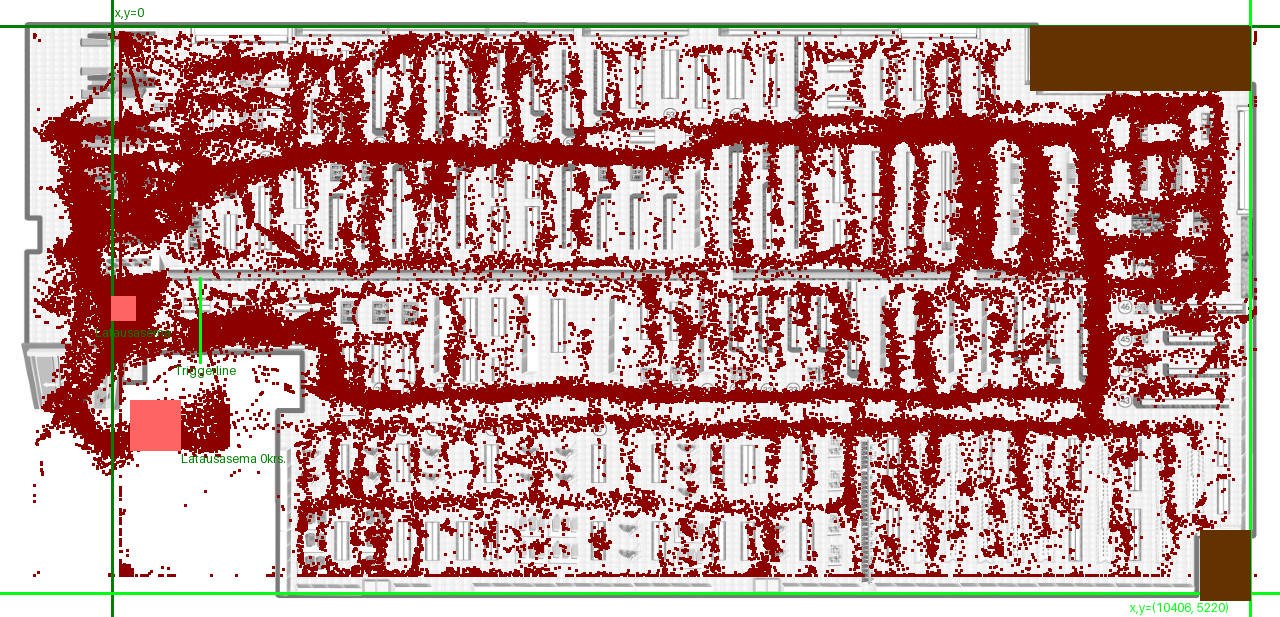

In [220]:
draw(df_plot)

### Onko jotain muuta?

- Poistetaan järjestelmän koordinaatiston vanhat rajoitteet. Ainakin aikaisemmassa versiossa x,y akselit olivat rajoitettu tiettyyn arvoon, esim x>=(-50), jos kärryt menivät yli rajojen. Tällöin jos kärry meni alle -50 arvoon, niin se tallennettiin x=-50

In [10]:
limited_left_val = df['x'].isin([-50])
limited_upper_val = df['y'].isin([150])
limited_lower_val = df['y'].isin([5050])

print("Löydetty:", limited_lower_val.value_counts()[True], limited_left_val.value_counts()[True], limited_upper_val.value_counts()[True], "kpl")

df = df[~limited_left_val & ~limited_upper_val & ~limited_lower_val]

Löydetty: 9448 37049 9919 kpl


In [11]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1040755 entries, 0 to 6489290
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype              
---  ------     --------------    -----              
 0   node_id    1040755 non-null  int32              
 1   timestamp  1040755 non-null  datetime64[ns, UTC]
 2   x          1040755 non-null  int32              
 3   y          1040755 non-null  int32              
dtypes: datetime64[ns, UTC](1), int32(3)
memory usage: 27.8 MB
